[1.32971447 0.30503349 0.08888152]


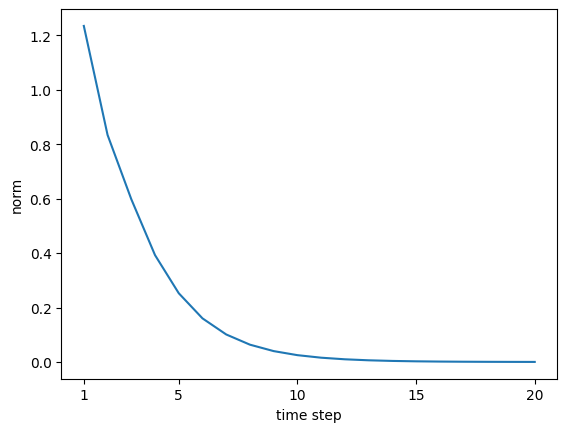

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

N = 2 #미니배치 크기
H = 3 #hidden state 벡터의 차원수
T = 20 # 시계열 데이터의 길이(=timestep)

dh = np.ones((N, H))
np.random.seed(3) # 재현할 수 있도록 난수의 시드 고정
Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N # L2 노름 
    norm_list.append(norm)

u, s, vh = np.linalg.svd(Wh)
print(s)

# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

In [2]:
import numpy as np

dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0 # threshold

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

In [3]:
print('before : ', dW1.flatten())
clip_grads(grads, max_norm)
print('after : ', dW1.flatten())

before :  [6.49144048 2.78487283 6.76254902 5.90862817 0.23981882 5.58854088
 2.59252447 4.15101197 2.83525082]
after :  [1.49503731 0.64138134 1.55747605 1.36081038 0.05523244 1.28709139
 0.59708178 0.95601551 0.65298384]


In [4]:
import sys
sys.path.append('..')
from common.np import *
from common.layers import *
from common.functions import sigmoid

class LSTM:
    def __init__(self, Wx, Wh, b):
        '''
        Parameters
        __________
        Wx: 입력 x에 대한 가중치 매개변수(4개분의 가중치가 담겨 있음)
        Wh: 은닉 상태 h에 대한 가중치 매개변수(4개분의 가중치가 담겨 있음)
        b: 편향(4개분의 편향이 담겨 있음)
        
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(Self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N,H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next
    
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1-i)
        df *= f * (1-f)
        do *= o * (1-o)
        dg *= (1-g**2)

        dA = np.hstack((df, dg, di, do)) # hstack : 가로로 연결(slice로 나눠졌던 4개의 값을 합치기)

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

In [5]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0,0

        grads = [0,0,0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs
        
    def set_state(self, h, c=None):
        self.h, self.c = h,c

    def reset_state(self):
        self.h, self.c = None, None            


## LSTM을 사용한 언어 모델

In [6]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel

class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V,D)/100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.lstm_layer.reset_state()

Done
| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 9999.69
| 에폭 1 |  반복 21 / 1327 | 시간 1[s] | 퍼플렉서티 2965.94
| 에폭 1 |  반복 41 / 1327 | 시간 2[s] | 퍼플렉서티 1249.31
| 에폭 1 |  반복 61 / 1327 | 시간 3[s] | 퍼플렉서티 974.55
| 에폭 1 |  반복 81 / 1327 | 시간 5[s] | 퍼플렉서티 788.17
| 에폭 1 |  반복 101 / 1327 | 시간 6[s] | 퍼플렉서티 659.48
| 에폭 1 |  반복 121 / 1327 | 시간 7[s] | 퍼플렉서티 644.74
| 에폭 1 |  반복 141 / 1327 | 시간 8[s] | 퍼플렉서티 604.28
| 에폭 1 |  반복 161 / 1327 | 시간 9[s] | 퍼플렉서티 587.50
| 에폭 1 |  반복 181 / 1327 | 시간 11[s] | 퍼플렉서티 592.19
| 에폭 1 |  반복 201 / 1327 | 시간 12[s] | 퍼플렉서티 499.94
| 에폭 1 |  반복 221 / 1327 | 시간 13[s] | 퍼플렉서티 490.74
| 에폭 1 |  반복 241 / 1327 | 시간 14[s] | 퍼플렉서티 445.08
| 에폭 1 |  반복 261 / 1327 | 시간 15[s] | 퍼플렉서티 473.24
| 에폭 1 |  반복 281 / 1327 | 시간 17[s] | 퍼플렉서티 463.11
| 에폭 1 |  반복 301 / 1327 | 시간 18[s] | 퍼플렉서티 397.16
| 에폭 1 |  반복 321 / 1327 | 시간 19[s] | 퍼플렉서티 348.54
| 에폭 1 |  반복 341 / 1327 | 시간 20[s] | 퍼플렉서티 406.64
| 에폭 1 |  반복 361 / 1327 | 시간 21[s] | 퍼플렉서티 414.41
| 에폭 1 |  반복 381 / 1327 | 시간 23[s] | 퍼플렉서티 332.74
| 에폭 1 

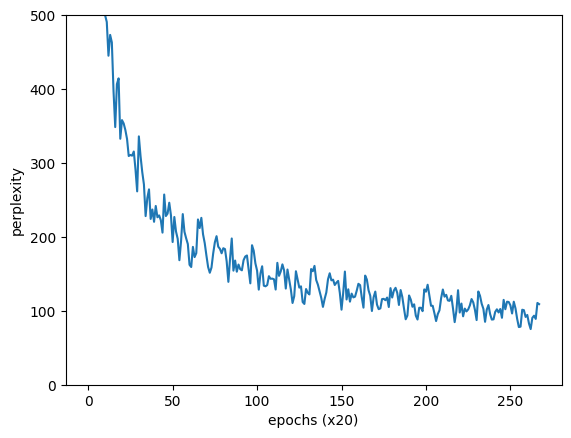

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티 :  135.45917176831196


In [9]:
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb

# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 35 # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0,500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티 : ', ppl_test)

# 매개변수 저장
model.save_params()


In [ ]:
%matplotlib inline
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb
from better_rnnlm import BetterRnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650 # RNN의 은닉 상태 벡터의 원소 수
time_size = 35 # RNN을 펼치는 크기
lr = 20.0
max_epoch = 3
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size, time_size=time_size, max_grad=max_grad)
    
    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티 : ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()

    else:
        lr /= 4.0
        optimizer.lr = lr
    
    model.reset_state()
    print('-' * 50)

model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티 : ', ppl_test)